In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sklearn
from tqdm import tqdm
df = pd.read_csv('moviecopy.csv')

2023-08-13 18:52:10.548187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df.isnull().sum()
#0 null so no need to clear null
print(df.duplicated().sum())
#418 duplicated, no we need to clear duplicates
df=df.drop_duplicates() 
print(df.duplicated().sum())
#duplicates are cleared
df.head()

0
0


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
import re
def stringClear(text):
    cleanText = re.sub(r'[!,.""?''()]',' ',text)
    return cleanText

df['text'] = df['text'].apply(stringClear)
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,label
0,i grew up b 1965 watching and loving the th...,0
1,when i put this movie in my dvd player and sa...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWordList = stopwords.words("english")

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stopWordList]).apply(lambda x:" ".join(x))
#unnecessary words are eliminated
df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eceokutan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1
5,terrible movie everyone said made laugh cameo ...,0
6,finally watched shocking movie last night dist...,1
7,caught film azn cable sounded like would good ...,0
8,may remake 1987 autumn's tale eleven years dir...,1


In [6]:

def catAsNum(val):
    if val=="positive":
        return 1
    else:
        return 0
df['label']  =  df['label'].apply(catAsNum)

In [7]:
x = df["text"].values
y = df["label"].values

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(7,)
(2,)
(7,)
(2,)


In [19]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token 
train_encodings = tokenizer(list(x_train), padding = "max_length", truncation=True)
test_encodings = tokenizer(list(x_test), padding = "max_length", truncation=True)
BATCHSIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(BATCHSIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(BATCHSIZE)




In [11]:
for x, y in test_dataset:
   print(x, y)

{'input_ids': <tf.Tensor: shape=(2, 1024), dtype=int32, numpy=
array([[15332,   760,  1948, ..., 50256, 50256, 50256],
       [   69,  3289,  7342, ..., 50256, 50256, 50256]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 1024), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>} tf.Tensor([0 0], shape=(2,), dtype=int64)


In [ ]:
""" 
import tensorflow_datasets as tfds
train_dataframe = tfds.as_dataframe(train_dataset) 
test_dataframe = tfds.as_dataframe(test_dataset) 
"""

' \nimport tensorflow_datasets as tfds\ntrain_dataframe = tfds.as_dataframe(train_dataset) \ntest_dataframe = tfds.as_dataframe(test_dataset) \n'

In [12]:
id2label = {
    0 : 'Negative',
    1 : 'Positive'
}

label2id = {v : k for k, v in id2label.items()}
num_classes = len(label2id)
print(label2id)

{'Negative': 0, 'Positive': 1}


In [13]:
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained(
    "gpt2",
    num_labels = 2,
    label2id = label2id,
    id2label = id2label)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), #hyperparameter
    metrics = ["accuracy"] #hyperparameter sayılır
)

All PyTorch model weights were used when initializing TFGPT2ForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.summary()

Model: "tfgpt2_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 score (Dense)               multiple                  1536      
                                                                 
 transformer (TFGPT2MainLay  multiple                  124439808 
 er)                                                             
                                                                 
Total params: 124441344 (474.71 MB)
Trainable params: 124441344 (474.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:

for element in train_dataset:  
  print(element)
for element in test_dataset:  
  print(element)
EPOCHS = 1 #hyperparameter
history = model.fit(
    train_dataset= train_dataset,
    validation_data = test_dataset,
    epochs = EPOCHS
)

({'input_ids': <tf.Tensor: shape=(7, 1024), dtype=int32, numpy=
array([[  320,  4656,  1327, ..., 50256, 50256, 50256],
       [11261, 28763, 12923, ..., 50256, 50256, 50256],
       [  353,  5547,  3807, ..., 50256, 50256, 50256],
       ...,
       [10197,   996,  1049, ..., 50256, 50256, 50256],
       [   66,  3413,  2646, ..., 50256, 50256, 50256],
       [ 1996,  3807,   288, ..., 50256, 50256, 50256]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7, 1024), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}, <tf.Tensor: shape=(7,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0])>)
({'input_ids': <tf.Tensor: shape=(2, 1024), dtype=int32, numpy=
array([[15332,   760,  1948, ..., 50256, 50256, 50256],
       [   69,  3289,  7342, ..., 50256, 50256, 50256]], dtype=int32)>, 'attention_mask': 

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/55/m_f_x3bd49n0hfdm6nm4wnnc0000gp/T/ipykernel_19010/4289122776.py", line 2, in <module>
      history = model.fit(
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/transformers/modeling_tf_utils.py", line 1676, in train_step
      loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/eceokutan/Library/Python/3.9/lib/python/site-packages/keras/src/backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [7168,2] and labels shape [7]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_32287]

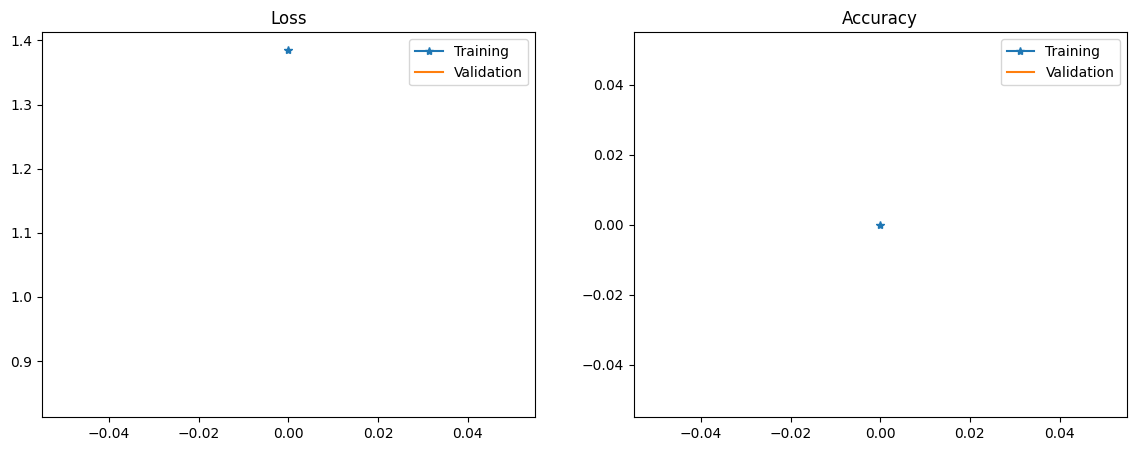

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

In [ ]:
out = model.predict(test_dataset)
pred = np.argmax(out[0], axis = 1)
pred

1/1 [==============================] - 4s 4s/step


array([1, 1])

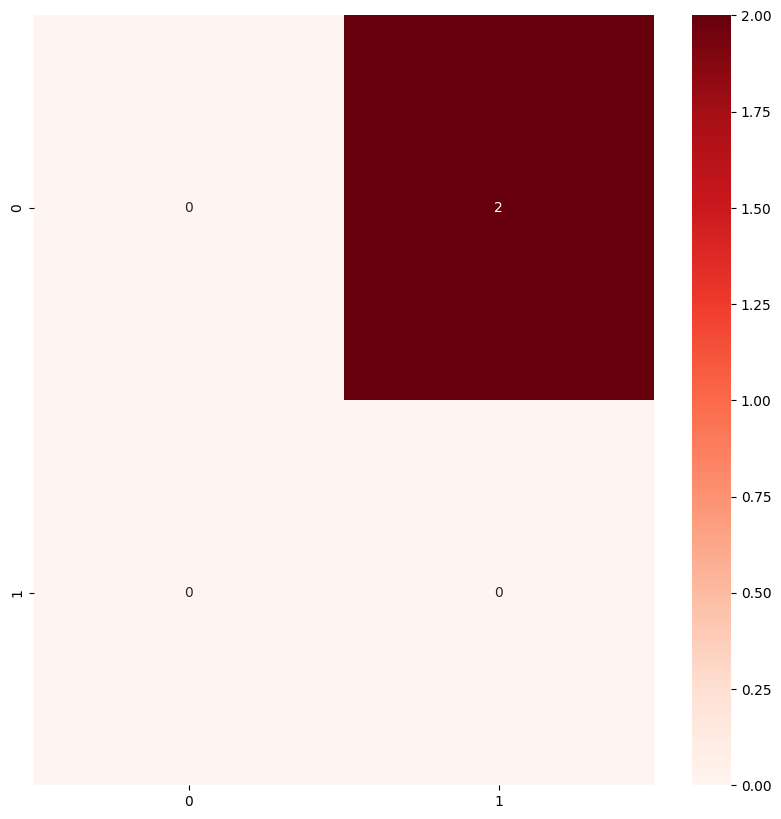

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred)
plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, cmap='Reds')
plt.show()